In [2]:
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# np.random.seed(42)
# tf.random.set_seed(42)

input_path="/Users/vishwas/Desktop/whatsapp/myweb.jpeg"
crop_file="/Users/vishwas/Desktop/build_my_web/crop/"

In [3]:
# !conda list tensorflow

In [4]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    #creats a something like generator and applies a funtion for each element (.map)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    #batch is like grouping into buckets 
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [5]:
# Find maximum length and the size of the vocabulary in the training data.
# train_labels_cleaned = []
max_len = 21
# characters=['.',
#  'q',
#  '"',
#  'W',
#  'v',
#  'n',
#  ':',
#  '4',
#  'g',
#  'B',
#  'p',
#  'M',
#  '-',
#  'S',
#  '7',
#  'L',
#  '9',
#  'C',
#  'z',
#  't',
#  "'",
#  '0',
#  '/',
#  '3',
#  '+',
#  ')',
#  'r',
#  '&',
#  'j',
#  'K',
#  'u',
#  'x',
#  'H',
#  ';',
#  'R',
#  '5',
#  '8',
#  '1',
#  'k',
#  'J',
#  '2',
#  's',
#  'c',
#  '(',
#  'T',
#  'm',
#  'N',
#  '!',
#  'E',
#  'X',
#  '6',
#  'G',
#  '#',
#  'U',
#  'P',
#  'e',
#  '?',
#  'l',
#  'i',
#  'I',
#  'b',
#  'd',
#  'f',
#  'Y',
#  'y',
#  'F',
#  'Q',
#  'O',
#  ',',
#  'h',
#  'A',
#  'V',
#  'Z',
#  'D',
#  '*',
#  'o',
#  'a',
#  'w']
# for label in train_labels:
#     label = label.split(" ")[-1].strip()
#     for char in label:
#         characters.add(char)

#     max_len = max(max_len, len(label))
#     train_labels_cleaned.append(label)
characters=['i', 'K', '/', 'T', 'z', 'a', ')', '+', 'D', 'n', '#', '3', 'd', 'S', '6', 's', 'h', 'p', 'W', ':', 'k', 'I', 'w', 'y', '!', 'H', 'R', 'q', 'o', '5', 'M', 'l', '8', '&', 'Y', 'L', 'P', '?', 'N', 'O', ',', 'v', '-', 'c', ';', 'C', 'G', '1', 'g', 'e', 'J', 'u', 'r', '"', 'j', '0', 'E', 'F', 'x', 'b', 'V', 'm', 'X', '.', 'Z', '7', 't', '*', '2', 'U', 'B', "'", 'Q', '4', 'f', '(', 'A', '9']
print("Maximum length: ", max_len)
print("Vocab size(alpha+num+punch): ", len(characters))
# print(len(train_labels_cleaned))

Maximum length:  21
Vocab size(alpha+num+punch):  78


In [6]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=characters, mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [8]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None,**kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
#         super(CustomLayer, self).__init__(name=name)
#         self.k = k
        super(CTCLayer, self).__init__(**kwargs)

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


# def build_model():
#     # Inputs to the model
#     input_img =  keras.Input(
#         shape=(image_width, image_height, 1), name="image")
#     labels =  keras.layers.Input(name="label", shape=(None,))

#     # First conv block.
#     x = keras.layers.Conv2D(
#         32,
#         (3, 3),
#         activation="relu",
#         kernel_initializer="he_normal",
#         padding="same",
#         name="Conv1",
#     )(input_img)
#     x =  keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

#     # Second conv block.
#     x =  keras.layers.Conv2D(
#         64,
#         (3, 3),
#         activation="relu",
#         kernel_initializer="he_normal",
#         padding="same",
#         name="Conv2",
#     )(x)
#     x =  keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

#     # We have used two max pool with pool size and strides 2.
#     # Hence, downsampled feature maps are 4x smaller. The number of
#     # filters in the last layer is 64. Reshape accordingly before
#     # passing the output to the RNN part of the model.
#     new_shape = ((image_width // 4), (image_height // 4) * 64)
#     x =  keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
#     x =  keras.layers.Dense(64, activation="relu", name="dense1")(x)
#     x =  keras.layers.Dropout(0.2)(x)

#     # RNNs.
#     x =  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
#     x =  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

#     # Output layer (the tokenizer is char-level)
#     # +2 is to account for the two special tokens introduced by the CTC loss.
#     # The recommendation comes here: https://git.io/J0eXP.
#     x =  keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)
    
#     # Add CTC layer for calculating CTC loss at each step.
#     output = CTCLayer(name="ctc_loss")(labels, x)

#     # Define the model.
#     model =  keras.models.Model(
#         inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
#     )
#     # Optimizer.
#     opt = keras.optimizers.Adam()
#     # Compile the model and return.
#     model.compile(optimizer=opt)
#     return model


# # Get the model.
# model = build_model()
# model.summary()

In [9]:
# base_path = "data"
# words_list = []

# words = open("/Users/vishwas/Desktop/build_my_web/data/words.txt", "r").readlines()
# for line in words:
#     if line[0]=='#':
#         continue
#     if line.split(" ")[1]!="err": # We don't need to deal with errored entries.
#         words_list.append(line)

# len(words_list)
# np.random.shuffle(words_list)
# split_idx = int(0.9 * len(words_list))
# train_samples = words_list[:split_idx]
# test_samples = words_list[split_idx:]

# val_split_idx = int(0.5 * len(test_samples))
# validation_samples = test_samples[:val_split_idx]
# test_samples = test_samples[val_split_idx:]

# assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

# print(f"Total training samples: {len(train_samples)}")
# print(f"Total validation samples: {len(validation_samples)}")
# print(f"Total test samples: {len(test_samples)}")

In [10]:
# base_image_path = "/Users/vishwas/Desktop/build_my_web/data/words"
# def get_image_paths_and_labels(samples):
#     paths = []
#     corrected_samples = []
#     for (i, file_line) in enumerate(samples):
#         line_split = file_line.strip()
#         line_split = line_split.split(" ")
        
#         # Each line split will have this format for the corresponding image:
#         # part1/part1-part2/part1-part2-part3.png
#         image_name = line_split[0] 
#         partI = image_name.split("-")[0]
#         partII = image_name.split("-")[1]
#         img_path =  os.path.join(base_image_path, partI, 
#             partI + "-" + partII,
#             image_name + ".png"
#         )
#         if os.path.getsize(img_path):
#             paths.append(img_path)
#             corrected_samples.append(file_line.split("\n")[0])
# #         print(file_line,"..",image_name,"..",partI,"..",partII,"..",img_path)
# #         break
#     return paths, corrected_samples


# validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
# test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [11]:
# base_image_path = "/Users/vishwas/Desktop/build_my_web/data/words"
# def get_image_paths_and_labels(samples):
#     paths = []
#     corrected_samples = []
#     for (i, file_line) in enumerate(samples):
#         line_split = file_line.strip()
#         line_split = line_split.split(" ")
        
#         # Each line split will have this format for the corresponding image:
#         # part1/part1-part2/part1-part2-part3.png
#         image_name = line_split[0] 
#         partI = image_name.split("-")[0]
#         partII = image_name.split("-")[1]
#         img_path =  os.path.join(base_image_path, partI, 
#             partI + "-" + partII,
#             image_name + ".png"
#         )
#         if os.path.getsize(img_path):
#             paths.append(img_path)
#             corrected_samples.append(file_line.split("\n")[0])
# #         print(file_line,"..",image_name,"..",partI,"..",partII,"..",img_path)
# #         break
#     return paths, corrected_samples


# # train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
# validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
# test_img_paths, test_labels = get_image_paths_and_labels(test_samples)
# def clean_labels(labels):
#     cleaned_labels = []
#     for label in labels:
#         label = label.split(" ")[-1].strip()
#         cleaned_labels.append(label)
#     return cleaned_labels


# validation_labels_cleaned = clean_labels(validation_labels)
# test_labels_cleaned = clean_labels(test_labels)

In [12]:
def distortion_free_resize(image, img_size):
    print(image)
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
                ]
        )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [13]:
# validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
# test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

In [14]:
new_model = tf.keras.models.load_model('model_20.h5', custom_objects={'CTCLayer': CTCLayer})

In [33]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from scipy.ndimage import interpolation as inter
input_file = input_path
img = im.open(input_file)
# convert to binary
wd, ht = img.size
pix = np.array(img.convert('1').getdata(), np.uint8)
bin_img = 1 - (pix.reshape((ht, wd)) / 255.0)
def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score
delta = 1
limit = 5
angles = np.arange(-limit, limit+delta, delta)
scores = []
for angle in angles:
    hist, score = find_score(bin_img, angle)
    scores.append(score)
best_score = max(scores)
best_angle = angles[scores.index(best_score)]
print('Best angle: {}'.format(best_angle))

import numpy as np
import cv2

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
image = cv2.imread(input_path)
i=rotate_image(image,2)
cv2.imwrite("r.jpg",i)


import cv2
import numpy as np

# Let's load a simple image with 3 black squares
image = cv2.imread(input_path)
# cv2.waitKey(0)

# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(gray, 30, 200)
# cv2.waitKey(0)

# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
contours, hierarchy = cv2.findContours(edged,
	cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# cv2.imshow('Canny Edges After Contouring', edged)
# cv2.waitKey(0)

print("Number of Contours found = " + str(len(contours)))

# Draw all contours
# -1 signifies drawing all contours
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1

# Blue color in BGR
color = (255, 0, 0)
  
# Line thickne
# cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
p=1
for c in contours:
        
        if  cv2.contourArea(c) < 100:
            continue  
        print(len(c))
        break
        x,y,w,h = cv2.boundingRect(c)
        print(cv2.contourArea(c),w,h)
#         cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255,0), 2)
#         image = cv2.putText(image, str((x,y)),(x,y), font, fontScale, color, 1, cv2.LINE_AA)
# (y+h-10 > 0) and (x+w-10>0 )and ((h*w)>5000) and (h<1000) and (w<1000) and (h > 90) and (w >90)
        if ((h > 150) or (w >150) ) :
#             and y+h-10 and ((y+h-10)-(y+10)) > 10) and ((x+w-25)-(x+25) >10)
#             print("dddd",h,w)
            cropped_image = image[y:y+h, x:x+w]
            
            cv2.imwrite(crop_file+str(p)+".jpg", cropped_image)
            p=p+1
    
        center = (x,y,w,h)
#         print (center)
# cv2.imshow('Contours', image)
# cv2.waitKey(0)
cv2.destroyAllWindows()

contours[0]

import cv2
import os

def load_images_from_folder(folder):
    images = []
    file=[]
    ids=[]
    ii=1
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
#             images.append(img)
            file.append(folder+str(filename))
            ids.append(str(ii))
            ii=ii+1
   
    return file,ids
f,ids=load_images_from_folder("/Users/vishwas/Desktop/whatsapp/all_pic/")
# f=["/Users/vishwas/Desktop/t2.png","/Users/vishwas/Desktop/whatsapp/c1.jpeg","/Users/vishwas/Desktop/segment0-2.png"]
# ids=[str(i) for i in range()]

Best angle: 0
Number of Contours found = 81
418


Tensor("DecodePng:0", shape=(None, None, 1), dtype=uint8)


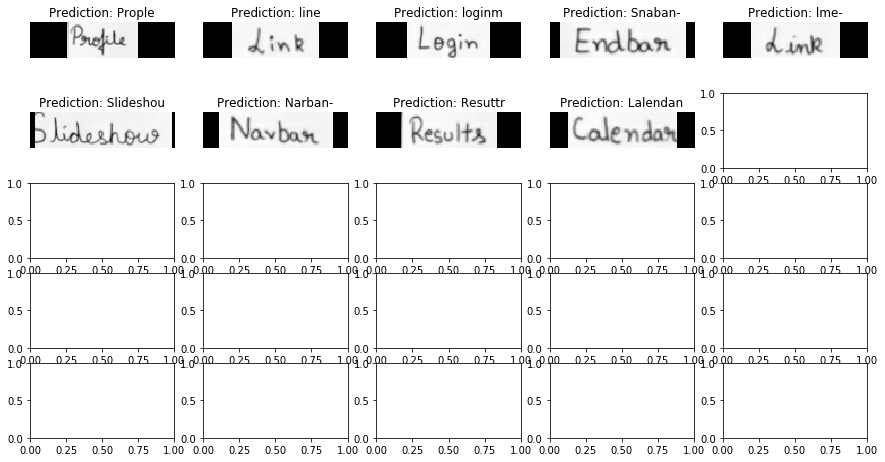

In [34]:
v_test=prepare_dataset(f, ids)
prediction_model = keras.models.Model(
    new_model.get_layer(name="image").input, new_model.get_layer(name="dense2").output
)
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
#         print(res)
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
#     with open('/Users/vishwas/Desktop/bd/model.txt', 'w') as f:
#         f.write(str(output_text))
    return output_text


#  Let's check results on some test samples.
for batch in v_test.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(5, 5, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(len(batch["image"])):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        gggg=5
        title = f"Prediction: {pred_texts[i]}"
        ax[i // gggg, i % gggg].imshow(img, cmap="gray")
        ax[i // gggg, i % gggg].set_title(title)
        ax[i // gggg, i % gggg].axis("off")

        
plt.show()

In [17]:
x=tf.constant(
[[14],
 [50],
 [62],
])
num_to_char(x)

<tf.Tensor: shape=(3, 1), dtype=string, numpy=
array([[b'S'],
       [b'e'],
       [b'm']], dtype=object)>

In [18]:
elemets=["button","input"]

In [19]:
# v=['/Users/vishwas/Desktop/build_my_web/crop/8.jpg',
#  '/Users/vishwas/Desktop/build_my_web/crop/4.jpg',
#  '/Users/vishwas/Desktop/build_my_web/crop/5.jpg',
#  '/Users/vishwas/Desktop/build_my_web/crop/7.jpg',
#  '/Users/vishwas/Desktop/build_my_web/crop/6.jpg',
#  '/Users/vishwas/Desktop/build_my_web/crop/2.jpg',
#  '/Users/vishwas/Desktop/build_my_web/crop/3.jpg',
#  '/Users/vishwas/Desktop/build_my_web/crop/1.jpg']
# v_file_name=["v.jpeg","2.jpeg","3.jpeg","4","8","9","10","web"]
# v_test=prepare_dataset(v, v_file_name)
# prediction_model = keras.models.Model(
#     new_model.get_layer(name="image").input, new_model.get_layer(name="dense2").output
# )
# def decode_batch_predictions(pred):
#     input_len = np.ones(pred.shape[0]) * pred.shape[1]
#     # Use greedy search. For complex tasks, you can use beam search.
#     results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
#         :, :max_len
#     ]
    
#     # Iterate over the results and get back the text.
#     output_text = []
#     for res in results:
#         res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
# #         print(res)
#         res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
#         output_text.append(res)
# #     with open('/Users/vishwas/Desktop/bd/model.txt', 'w') as f:
# #         f.write(str(output_text))
#     return output_text


# #  Let's check results on some test samples.
# for batch in v_test.take(1):
#     batch_images = batch["image"]
#     _, ax = plt.subplots(4, 4, figsize=(15, 8))

#     preds = prediction_model.predict(batch_images)
#     pred_texts = decode_batch_predictions(preds)

#     for i in range(len(batch["image"])):
#         img = batch_images[i]
#         img = tf.image.flip_left_right(img)
#         img = tf.transpose(img, perm=[1, 0, 2])
#         img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
#         img = img[:, :, 0]

#         title = f"Prediction: {pred_texts[i]}"
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")

        
# plt.show()

In [20]:
# prediction_model = keras.models.Model(
#     new_model.get_layer(name="image").input, new_model.get_layer(name="dense2").output
# )
# def decode_batch_predictions(pred):
# #     print(pred)
#     input_len = np.ones(pred.shape[0]) * pred.shape[1]
#     # Use greedy search. For complex tasks, you can use beam search.
#     results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
#         :, :max_len
#     ]
#     with open('/Users/vishwas/Desktop/bd/new_model.txt', 'w') as f:
#         f.write(str(results))
#     # Iterate over the results and get back the text.
#     output_text = []
#     for res in results:
#         res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
# #         print(res)
#         res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
#         output_text.append(res)
# #     with open('/Users/vishwas/Desktop/bd/new_model.txt', 'w') as f:
# #         f.write(str(output_text))
#     return output_text


# #  Let's check results on some test samples.
# for batch in test_ds.take(1):
#     batch_images = batch["image"]
#     _, ax = plt.subplots(4, 4, figsize=(15, 8))

#     preds = prediction_model.predict(batch_images)
#     pred_texts = decode_batch_predictions(preds)

#     for i in range(16):
#         img = batch_images[i]
#         img = tf.image.flip_left_right(img)
#         img = tf.transpose(img, perm=[1, 0, 2])
#         img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
#         img = img[:, :, 0]

#         title = f"Prediction: {pred_texts[i]}"
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")

# plt.show()

In [21]:
import cv2
import numpy as np

img = cv2.imread(input_path)

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if (angle < -45):
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 


In [22]:
image = img

gray = get_grayscale(image)
thresh = thresholding(gray)
cv2.imwrite("white.jpg",thresh)

True

In [23]:
cv2.imshow("canny",thresh)
cv2.waitKey(0)

13

In [24]:
import os
import cv2
import numpy as np


def segment_word(image, directory, count):

    word_dir = directory + "/words"
    if not os.path.exists(word_dir):
        os.makedirs(word_dir)
    # get threshold for pixel values
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    ret, thresh2 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    # dilate the image
    kernel = np.ones((5, 40), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    # find contours
    im2, ctrs, hier = cv2.findContours(
        img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # sort contours
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    sorted_ctrs = sorted_ctrs[0:]

    words = []

    for i, ctr in enumerate(sorted_ctrs):

        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)

        # Used to remove stray elements
        if ((w*h) < 1000):
            continue

        # Getting ROI
        roi = thresh2[y:y+h, x:x+w]

        # add each segmented image to list
        words.append(roi)
        cv2.imwrite(os.path.join(word_dir, str(count).zfill(
            2) + "-" + str(i).zfill(2) + ".png"), roi)

    return words

In [25]:
import cv2


def captch_ex(file_name):
    img = cv2.imread(file_name)

    img_final = cv2.imread(file_name)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY)  # for black text , cv.THRESH_BINARY_INV
    '''
            line  8 to 12  : Remove noisy portion 
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,
                                                         3))  # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more
    dilated = cv2.dilate(new_img, kernel, iterations=9)  # dilate , more the iteration more the dilation

    # for cv2.x.x

    contours = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # findContours returns 3 variables for getting contours
    # for cv3.x.x comment above line and uncomment line below

    #image, contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)


    for contour in contours:
        print(contour[0])
        # get rectangle bounding contour
        x, y, w, h = cv2.boundingRect(contour[0])

        # Don't plot small false positives that aren't text
        if w < 35 and h < 35:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(np.float32(img), (x, y), (x + w, y + h), (255, 0, 255), 2)

        '''
        #you can crop image and send to OCR  , false detected will return no text :)
        cropped = img_final[y :y +  h , x : x + w]

        s = file_name + '/crop_' + str(index) + '.jpg' 
        cv2.imwrite(s , cropped)
        index = index + 1

        '''
    # write original image with added contours to disk
    cv2.imshow('captcha_result', img)
    cv2.waitKey()


# file_name = '/Users/vishwas/Desktop/whatsapp/c.jpeg'
captch_ex(file_name)

NameError: name 'file_name' is not defined

In [ ]:
image = cv2.imread('/Users/vishwas/Desktop/t2.png')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([0, 0, 218])
upper = np.array([157, 54, 255])
mask = cv2.inRange(hsv, lower, upper)
cv2.imshow('captcha_result', mask)
cv2.waitKey(0)